The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0
!pip install -U mxnet-cu101==1.7.0


# Concise Implementation for Multiple GPUs
:label:`sec_multi_gpu_concise`

Implementing parallelism from scratch for every new model is no fun. Moreover, there is significant benefit in optimizing synchronization tools for high performance. In the following we will show how to do this using high-level APIs of deep learning frameworks.
The mathematics and the algorithms are the same as in :numref:`sec_multi_gpu`.
Quite unsurprisingly you will need at least two GPUs to run code of this section.


In [1]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## [**A Toy Network**]

Let's use a slightly more meaningful network than LeNet from :numref:`sec_multi_gpu` that is still sufficiently easy and quick to train.
We pick a ResNet-18 variant :cite:`He.Zhang.Ren.ea.2016`. Since the input images are tiny we modify it slightly. In particular, the difference from :numref:`sec_resnet` is that we use a smaller convolution kernel, stride, and padding at the beginning.
Moreover, we remove the max-pooling layer.


In [2]:
#@save
def resnet18(num_classes):
    """A slightly modified ResNet-18 model."""
    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(d2l.Residual(
                    num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(d2l.Residual(num_channels))
        return blk

    net = nn.Sequential()
    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the max-pooling layer
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))
    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

## Network Initialization


The `initialize` function allows us to initialize parameters on a device of our choice.
For a refresher on initialization methods see :numref:`sec_numerical_stability`. What is particularly convenient is that it also allows us to initialize the network on *multiple* devices simultaneously. Let's try how this works in practice.


In [3]:
net = resnet18(10)
# Get a list of GPUs
devices = d2l.try_all_gpus()
# Initialize all the parameters of the network
net.initialize(init=init.Normal(sigma=0.01), ctx=devices)

Using the `split_and_load` function introduced in :numref:`sec_multi_gpu` we can divide a minibatch of data and copy portions to the list of devices provided by the `devices` variable. The network instance *automatically* uses the appropriate GPU to compute the value of the forward propagation. Here we generate 4 observations and split them over the GPUs.


In [4]:
x = np.random.uniform(size=(4, 1, 28, 28))
x_shards = gluon.utils.split_and_load(x, devices)
net(x_shards[0]), net(x_shards[1])

[10:05:53] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


(array([[ 2.2610207e-06,  2.2045981e-06, -5.4046786e-06,  1.2869955e-06,
          5.1373163e-06, -3.8297967e-06,  1.4339059e-07,  5.4683451e-06,
         -2.8279192e-06, -3.9651104e-06],
        [ 2.0698672e-06,  2.0084667e-06, -5.6382510e-06,  1.0498458e-06,
          5.5506434e-06, -4.1065491e-06,  6.0830087e-07,  5.4521784e-06,
         -3.7365021e-06, -4.1891640e-06]], ctx=gpu(0)),
 array([[ 2.4629783e-06,  2.6015525e-06, -5.4362617e-06,  1.2938218e-06,
          5.6387889e-06, -4.1360108e-06,  3.5758853e-07,  5.5125256e-06,
         -3.1957325e-06, -4.2976326e-06],
        [ 1.9431673e-06,  2.2600434e-06, -5.2698201e-06,  1.4807417e-06,
          5.4830934e-06, -3.9678889e-06,  7.5751018e-08,  5.6764356e-06,
         -3.2530229e-06, -4.0943951e-06]], ctx=gpu(1)))

Once data passes through the network, the corresponding parameters are initialized *on the device the data passed through*.
This means that initialization happens on a per-device basis. Since we picked GPU 0 and GPU 1 for initialization, the network is initialized only there, and not on the CPU. In fact, the parameters do not even exist on the CPU. We can verify this by printing out the parameters and observing any errors that might arise.


In [5]:
weight = net[0].params.get('weight')

try:
    weight.data()
except RuntimeError:
    print('not initialized on cpu')
weight.data(devices[0])[0], weight.data(devices[1])[0]

not initialized on cpu


(array([[[ 0.01382882, -0.01183044,  0.01417865],
         [-0.00319718,  0.00439528,  0.02562625],
         [-0.00835081,  0.01387452, -0.01035946]]], ctx=gpu(0)),
 array([[[ 0.01382882, -0.01183044,  0.01417865],
         [-0.00319718,  0.00439528,  0.02562625],
         [-0.00835081,  0.01387452, -0.01035946]]], ctx=gpu(1)))

Next, let's replace the code to [**evaluate the accuracy**] by one that works (**in parallel across multiple devices**). This serves as a replacement of the `evaluate_accuracy_gpu` function from :numref:`sec_lenet`. The main difference is that we split a minibatch before invoking the network. All else is essentially identical.


In [6]:
#@save
def evaluate_accuracy_gpus(net, data_iter, split_f=d2l.split_batch):
    """Compute the accuracy for a model on a dataset using multiple GPUs."""
    # Query the list of devices
    devices = list(net.collect_params().values())[0].list_ctx()
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for features, labels in data_iter:
        X_shards, y_shards = split_f(features, labels, devices)
        # Run in parallel
        pred_shards = [net(X_shard) for X_shard in X_shards]
        metric.add(sum(float(d2l.accuracy(pred_shard, y_shard)) for
                       pred_shard, y_shard in zip(
                           pred_shards, y_shards)), labels.size)
    return metric[0] / metric[1]

## [**Training**]

As before, the training code needs to perform several basic functions for efficient parallelism:

* Network parameters need to be initialized across all devices.
* While iterating over the dataset minibatches are to be divided across all devices.
* We compute the loss and its gradient in parallel across devices.
* Gradients are aggregated and parameters are updated accordingly.

In the end we compute the accuracy (again in parallel) to report the final performance of the network. The training routine is quite similar to implementations in previous chapters, except that we need to split and aggregate data.


In [7]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx = [d2l.try_gpu(i) for i in range(num_gpus)]
    net.initialize(init=init.Normal(sigma=0.01), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        timer.start()
        for features, labels in train_iter:
            X_shards, y_shards = d2l.split_batch(features, labels, ctx)
            with autograd.record():
                ls = [loss(net(X_shard), y_shard) for X_shard, y_shard
                      in zip(X_shards, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
        npx.waitall()
        timer.stop()
        animator.add(epoch + 1, (evaluate_accuracy_gpus(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(ctx)}')

Let's see how this works in practice. As a warm-up we [**train the network on a single GPU.**]


test acc: 0.93, 13.3 sec/epoch on [gpu(0)]


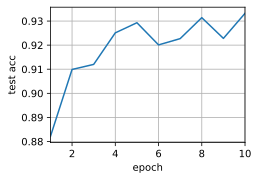

In [8]:
train(num_gpus=1, batch_size=256, lr=0.1)

Next we [**use 2 GPUs for training**]. Compared with LeNet
evaluated in :numref:`sec_multi_gpu`,
the model for ResNet-18 is considerably more complex. This is where parallelization shows its advantage. The time for computation is meaningfully larger than the time for synchronizing parameters. This improves scalability since the overhead for parallelization is less relevant.


test acc: 0.93, 6.9 sec/epoch on [gpu(0), gpu(1)]


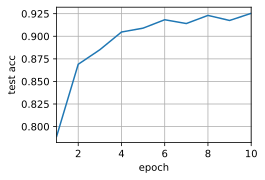

In [9]:
train(num_gpus=2, batch_size=512, lr=0.2)

## Summary


* Gluon provides primitives for model initialization across multiple devices by providing a context list.


* Data is automatically evaluated on the devices where the data can be found.
* Take care to initialize the networks on each device before trying to access the parameters on that device. Otherwise you will encounter an error.
* The optimization algorithms automatically aggregate over multiple GPUs.



## Exercises


1. This section uses ResNet-18. Try different epochs, batch sizes, and learning rates. Use more GPUs for computation. What happens if you try this with 16 GPUs (e.g., on an AWS p2.16xlarge instance)?
1. Sometimes, different devices provide different computing power. We could use the GPUs and the CPU at the same time. How should we divide the work? Is it worth the effort? Why? Why not?
1. What happens if we drop `npx.waitall()`? How would you modify training such that you have an overlap of up to two steps for parallelism?


[Discussions](https://discuss.d2l.ai/t/365)
